<b><font size="6">Data-Driven Marketing with Google Merch Store Customer Data</font>

    Notebook by Allison Kelly - allisonkelly42@gmail.com

    Blog post - placeholder

    Presentation - placeholder

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Imports" data-toc-modified-id="Imports-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Customer-Lifetime-Value-and-Customer-Attrition-Prediction" data-toc-modified-id="Customer-Lifetime-Value-and-Customer-Attrition-Prediction-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Customer Lifetime Value and Customer Attrition Prediction</a></span><ul class="toc-item"><li><span><a href="#Obtaining-the-data" data-toc-modified-id="Obtaining-the-data-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Obtaining the data</a></span></li><li><span><a href="#Cleaning-the-Data" data-toc-modified-id="Cleaning-the-Data-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Cleaning the Data</a></span></li><li><span><a href="#Exploratory-Data-Analysis" data-toc-modified-id="Exploratory-Data-Analysis-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Exploratory Data Analysis</a></span></li><li><span><a href="#Modeling" data-toc-modified-id="Modeling-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Modeling</a></span></li></ul></li><li><span><a href="#Future-Work" data-toc-modified-id="Future-Work-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Future Work</a></span></li></ul></div>

# Introduction

Leveraging machine learning and AI with the massive amounts of consumer history, web traffic, and product reviews can have a measurable impact on marketing campaigns. By harnessing the power of statistical and analytical tools, patterns untracked by basic dashboards can be unearthed, translating into higher conversion rates over traditional marketing strategies. The following notebook is one such demonstration of this power.

Part one explores customer purchase history on the <a href="https://shop.googlemerchandisestore.com/">Google Merchandise Store.</a> By using machine learning, I will predict the customer lifetime value (CLV) of each customer. This data can then be used to segment ads, email marketing campaigns, and other traditional marketing ventures. I will also predict and measure customer attrition which can be used to develop proactive prevention strategies and increase revenue. 

Part two uses NLP to parse through Google Play store app reviews, conduct sentiment analysis, and classify reviews. The NLP machine learning models can be used to recommend apps and get feedback in realtime to prompt bug fixes and improvements. You'll find this in a separate notebook <b>here.</b> 

Finally, part three will focusing on tracking important metrics and gleaning insights from the Google Analytics demo account for the Google Merchandise Store. Setting benchmarks for KPIs and tracking campaign results are essential to understanding consumer behavior and making informed business decisions. PLACEHOLDER FOR WHERE THIS CAN BE FOUND

# Imports

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns 
import datetime
import numpy as np
import json # for data cleaning
import dill
import pickle

import warnings # Ignoring warnings
warnings.filterwarnings("ignore")

from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics

# Customer Lifetime Value and Customer Attrition Prediction

In marketing, according to <a href="https://en.wikipedia.org/wiki/Customer_lifetime_value">Wikipedia</a>, Customer Lifetime Value (CLV) can be defined as "a prediction of the net profit attributed to the entire future relationship with a customer." CLV is an important metric to track as it can help identify your customer acquisition budget, help your marketing team to segment your customer base, increase retention and satisfaction, etc. CLV is represented as a dollar amount and varies customer to customer. 

<img src="brandwise-clv-bellcurve.gif">

## Obtaining the data

This dataset was derived from the Google Merchandise Store demo account as provided by Google BigQuery on Kaggle. You can find the data <a href="https://www.kaggle.com/c/ga-customer-revenue-prediction">here.</a> 

In [2]:
df = pd.read_csv('train.csv') # loading and checking out the dataset
df.head()

/Users/Allie/anaconda3/envs/learn-env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,channelGrouping,date,device,fullVisitorId,geoNetwork,sessionId,socialEngagementType,totals,trafficSource,visitId,visitNumber,visitStartTime
0,Organic Search,20171016,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",6167871330617112363,"{""continent"": ""Asia"", ""subContinent"": ""Southea...",6167871330617112363_1508151024,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""4"", ""pageviews"": ""4""}","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1508151024,2,1508151024
1,Organic Search,20171016,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",0643697640977915618,"{""continent"": ""Europe"", ""subContinent"": ""South...",0643697640977915618_1508175522,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""5"", ""pageviews"": ""5"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1508175522,1,1508175522
2,Organic Search,20171016,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",6059383810968229466,"{""continent"": ""Europe"", ""subContinent"": ""Weste...",6059383810968229466_1508143220,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""7"", ""pageviews"": ""7"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1508143220,1,1508143220
3,Organic Search,20171016,"{""browser"": ""Safari"", ""browserVersion"": ""not a...",2376720078563423631,"{""continent"": ""Americas"", ""subContinent"": ""Nor...",2376720078563423631_1508193530,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""8"", ""pageviews"": ""4"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1508193530,1,1508193530
4,Organic Search,20171016,"{""browser"": ""Safari"", ""browserVersion"": ""not a...",2314544520795440038,"{""continent"": ""Americas"", ""subContinent"": ""Nor...",2314544520795440038_1508217442,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""9"", ""pageviews"": ""4"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1508217442,1,1508217442


In [3]:
print(df.info())

print('\n\nNumber of individual visitors to the Google Merch Store: ', 
      len(df.fullVisitorId.unique()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 804684 entries, 0 to 804683
Data columns (total 12 columns):
channelGrouping         804684 non-null object
date                    804684 non-null int64
device                  804684 non-null object
fullVisitorId           804684 non-null object
geoNetwork              804684 non-null object
sessionId               804684 non-null object
socialEngagementType    804684 non-null object
totals                  804684 non-null object
trafficSource           804684 non-null object
visitId                 804684 non-null int64
visitNumber             804684 non-null int64
visitStartTime          804684 non-null int64
dtypes: int64(4), object(8)
memory usage: 73.7+ MB
None


Number of individual visitors to the Google Merch Store:  652237


The dataframe is consisted of 903,653 datapoints describing visits to the Google Merch Store with 742,753 unique visitors. Most features consist of objects, though the integers are either dates, times or immutable ID numbers that should be categorized accordingly. 

## Cleaning the Data

In [4]:

def datetime_edits(dataframe):
    
    """This function changes the two columns 
    with dates/times into datetime objects.
    To be used with dataframes with similar
    setup to this one."""
    
    try:
        dataframe.date.astype(str)
        dataframe.date = pd.to_datetime(dataframe.date, 
                                        format='%Y%m%d')
    except:
        print("Your dataframe does not contain a 'date' column.")
        
    try:
        dataframe.visitStartTime = pd.to_datetime(dataframe.visitStartTime, unit='s')
    
    except:
        print("Your dataframe does not containt a 'visitStartTime' column.")
    
    # confirming proper edits were made
    return "Date column:", dataframe.date.dtype, "Time column:", dataframe.visitStartTime.dtype


In [5]:
datetime_edits(df)

('Date column:', dtype('<M8[ns]'), 'Time column:', dtype('<M8[ns]'))

In [6]:
# changing immutable IDs to strings
df.visitId = df.visitId.astype(str)

In [7]:

def unpack_col(df, col):
    
    '''Some column values are dictionary-like strings.
    This function unpacks those values, creating new
    columns for each key that can then be analyzed 
    as separate features. Returns dataframe of 
    unpacked column, not including original column.
    '''
    
    df[col] = df[col].dropna().apply(json.loads)
    unpacked_df = df[col].apply(pd.Series)
        
    return unpacked_df
        
geo_df = unpack_col(df, 'geoNetwork')
totals_df = unpack_col(df, 'totals')


In [8]:
df_expanded = pd.concat([df, geo_df, totals_df], axis=1)

In [9]:
df_expanded.head()

,channelGrouping,date,device,fullVisitorId,geoNetwork,sessionId,socialEngagementType,totals,trafficSource,visitId,...,cityId,networkDomain,latitude,longitude,networkLocation,visits,hits,pageviews,newVisits,bounces
0,Organic Search,2017-10-16,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",6167871330617112363,"{'continent': 'Asia', 'subContinent': 'Southea...",6167871330617112363_1508151024,Not Socially Engaged,"{'visits': '1', 'hits': '4', 'pageviews': '4'}","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1508151024,...,not available in demo dataset,myrepublic.com.sg,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,4,4,NaN,NaN
1,Organic Search,2017-10-16,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",0643697640977915618,"{'continent': 'Europe', 'subContinent': 'South...",0643697640977915618_1508175522,Not Socially Engaged,"{'visits': '1', 'hits': '5', 'pageviews': '5',...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1508175522,...,not available in demo dataset,rima-tde.net,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,5,5,1,NaN
2,Organic Search,2017-10-16,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",6059383810968229466,"{'continent': 'Europe', 'subContinent': 'Weste...",6059383810968229466_1508143220,Not Socially Engaged,"{'visits': '1', 'hits': '7', 'pageviews': '7',...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1508143220,...,not available in demo dataset,sfr.net,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,7,7,1,NaN
3,Organic Search,2017-10-16,"{""browser"": ""Safari"", ""browserVersion"": ""not a...",2376720078563423631,"{'continent': 'Americas', 'subContinent': 'Nor...",2376720078563423631_1508193530,Not Socially Engaged,"{'visits': '1', 'hits': '8', 'pageviews': '4',...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1508193530,...,not available in demo dataset,(not set),not available in demo dataset,not available in demo dataset,not available in demo dataset,1,8,4,1,NaN
4,Organic Search,2017-10-16,"{""browser"": ""Safari"", ""browserVersion"": ""not a...",2314544520795440038,"{'continent': 'Americas', 'subContinent': 'Nor...",2314544520795440038_1508217442,Not Socially Engaged,"{'visits': '1', 'hits': '9', 'pageviews': '4',...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1508217442,...,not available in demo dataset,(not set),not available in demo dataset,not available in demo dataset,not available in demo dataset,1,9,4,1,NaN


In [10]:
# Dropping unpacked columns 

df_expanded = df_expanded.drop('geoNetwork', axis=1)
df_expanded = df_expanded.drop('totals', axis=1)

The nested information in the device and trafficSource columns would be necessary for an analysis of ad quality, but we're concerned with what the customer does once they get to the store, not how they get there. We'll drop those columns as well. 

In [11]:
df_expanded = df_expanded.drop(['device', 'trafficSource'], axis=1)

In [12]:

# Identifying columns that have no variation
cols = list(df_expanded.columns)

one_variant = []
for col in cols:
    if len(df_expanded[col].unique()) == 1:
        print(df_expanded[col].unique())
        one_variant.append(col)
one_variant

['Not Socially Engaged']
['not available in demo dataset']
['not available in demo dataset']
['not available in demo dataset']
['not available in demo dataset']
['1']


['socialEngagementType',
 'cityId',
 'latitude',
 'longitude',
 'networkLocation',
 'visits']

Columns with no variation in value will be dropped. Some columns in a full dataset such as language could be relevant to CLV, but since we don't have that information available through the Google Demo Account, we'll remove those columns. 

In [13]:
df_expanded = df_expanded.drop(one_variant, axis=1)

Because our unique customer identifier is tied to 'fullVisitorId' and 'visitStartTime' describes the frequency (or lacktherof) of visits to the store, we can safely remove 'sessionId' and 'visitId'.

In [14]:
df_expanded = df_expanded.drop(['visitId', 'sessionId'], axis=1)

Columns 'region,' 'metro,' and 'city' may have an impact on whether or not a customer will spend in the future and how much due to income levels and cost of living, however most of the information in these categories is not available. We'll drop these columns for this project, though you may consider leaving them if other datasets give a more detailed look into the customers location. We can also drop 'continent' and 'subcontinent' because the country names themselves give us that information inherently. 

In [15]:
# Only keeping country column to identify location of transaction
df_expanded = df_expanded.drop(['region', 'metro', 'city', 'continent', 'subContinent' ], axis=1)

In [16]:
# Removing parentheses around "Other" channel group
df_expanded.channelGrouping = df_expanded.channelGrouping.str.strip('()')

Finally, we'll drop the 'networkDomain' column as it doesn't pertain to the prediction of CLV. 

In [17]:
df_expanded.drop('networkDomain', axis=1, inplace=True)

In [18]:
df_expanded.isna().any()

channelGrouping    False
date               False
fullVisitorId      False
visitNumber        False
visitStartTime     False
country            False
hits               False
pageviews           True
newVisits           True
bounces             True
dtype: bool

In [19]:
# Replacing a variant of NaN with 'Unknown'
df_expanded = df_expanded.replace('(not set)', 'Unknown')

In [21]:
nan_cols = ['pageviews', 'bounces', 'newVisits', 'transactionRevenue']
for col in nan_cols: 
    
    print(f'{col} NaN: ', df_expanded[col].isnull().sum())
    print(f'{col} datatype: ', df_expanded[col].dtype, '\n')

pageviews NaN:  139
pageviews datatype:  object 

bounces NaN:  383736
bounces datatype:  object 

newVisits NaN:  200314
newVisits datatype:  object 



Each of the columns that contain null values are related to the customer's behavior once on the site. We can change the NaNs to 0 to indicate no pages were viewed, the customer did not bounce, the customer has been to the merch store previously, and the customer did not purchase from the store. We also need to correct the datatype of 'transactionRevenue' from object to float. 

In [22]:
df_expanded.fillna('0', inplace=True)

In [ ]:
df_expanded.transactionRevenue = df_expanded.transactionRevenue.astype('float')

In [23]:
for col in df_expanded.columns:
    print(df_expanded[col].value_counts().head())

Organic Search    357402
Direct            130108
Social            128854
Referral          106469
Display            45021
Name: channelGrouping, dtype: int64
2017-12-12    9234
2017-12-13    9131
2017-10-04    5122
2017-09-20    4880
2017-09-21    4715
Name: date, dtype: int64
7282998257608986241    190
3884810646891698298    154
0348420048060754000    127
7477638593794484792    121
7122741899604173060    119
Name: fullVisitorId, dtype: int64
1    604370
2     89994
3     35119
4     18729
5     11699
Name: visitNumber, dtype: int64
2017-12-13 00:29:41    28
2017-12-13 00:31:38    28
2017-12-13 00:29:09    26
2017-12-13 00:29:57    24
2017-12-13 00:30:08    24
Name: visitStartTime, dtype: int64
United States     352473
India              54177
United Kingdom     35948
Canada             25188
Germany            18536
Name: country, dtype: int64
1    417310
2     99547
3     64033
4     38431
5     32748
Name: hits, dtype: int64
1    423806
2    106024
3     69061
4     41474
5     3

In [24]:
df_expanded.to_csv('cleaned_df.csv', index=False)

## Exploratory Data Analysis

In [3]:
df = pd.read_csv('cleaned_df.csv')
df.head()

,channelGrouping,date,fullVisitorId,visitNumber,visitStartTime,country,hits,pageviews,bounces,newVisits,transactionRevenue
0,Organic Search,2016-09-02 00:00:00,1131660440785968503,1,2016-09-02 15:33:05,Turkey,1,1,1,1,0.0
1,Organic Search,2016-09-02 00:00:00,377306020877927890,1,2016-09-03 05:22:27,Australia,1,1,1,1,0.0
2,Organic Search,2016-09-02 00:00:00,3895546263509774583,1,2016-09-03 01:16:26,Spain,1,1,1,1,0.0
3,Organic Search,2016-09-02 00:00:00,4763447161404445595,1,2016-09-03 05:40:13,Indonesia,1,1,1,1,0.0
4,Organic Search,2016-09-02 00:00:00,27294437909732085,2,2016-09-02 13:23:20,United Kingdom,1,1,1,0,0.0


In [4]:
df.describe()

,visitNumber,hits,pageviews,bounces,newVisits,transactionRevenue
count,903653.000000,903653.000000,903653.000000,903653.000000,903653.000000,9.036530e+05
mean,2.264897,4.596538,3.849338,0.498676,0.778020,1.704273e+06
std,9.283735,9.641437,7.025002,0.499999,0.415578,5.277866e+07
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000e+00
50%,1.000000,2.000000,1.000000,0.000000,1.000000,0.000000e+00
75%,1.000000,4.000000,4.000000,1.000000,1.000000,0.000000e+00
max,395.000000,500.000000,469.000000,1.000000,1.000000,2.312950e+10


The dataset is pulled through Google Analytics BigQuery, and according to the BigQuery cookbook, transaction revenue is in USD * 10^6. We'll need to add a negligable amount to each transaction (to avoid dividing by 0) and take the log of the transactionRevenue column before we proceed with data exploration.

In [5]:
df['logRevenue'] = np.log(df.transactionRevenue+.001)

In [6]:
df.head()

,channelGrouping,date,fullVisitorId,visitNumber,visitStartTime,country,hits,pageviews,bounces,newVisits,transactionRevenue,logRevenue
0,Organic Search,2016-09-02 00:00:00,1131660440785968503,1,2016-09-02 15:33:05,Turkey,1,1,1,1,0.0,-6.907755
1,Organic Search,2016-09-02 00:00:00,377306020877927890,1,2016-09-03 05:22:27,Australia,1,1,1,1,0.0,-6.907755
2,Organic Search,2016-09-02 00:00:00,3895546263509774583,1,2016-09-03 01:16:26,Spain,1,1,1,1,0.0,-6.907755
3,Organic Search,2016-09-02 00:00:00,4763447161404445595,1,2016-09-03 05:40:13,Indonesia,1,1,1,1,0.0,-6.907755
4,Organic Search,2016-09-02 00:00:00,27294437909732085,2,2016-09-02 13:23:20,United Kingdom,1,1,1,0,0.0,-6.907755


In [7]:
purchase_df = df.loc[df.transactionRevenue > 0.0]

print('Our timeline begins: ', df.visitStartTime.min(), 'and ends: ', df.visitStartTime.max())
print(f'{len(purchase_df)} customers made purchases during that time period totalling {round(purchase_df.logRevenue.sum(),2)}')


Our timeline begins:  2016-08-01 07:00:12 and ends:  2017-08-02 06:59:53
11515 customers made purchases during that time period totalling 205236.02


The vast majority of visits to the Google Merch Store did NOT yield purchases.

In [8]:
round(purchase_df.logRevenue.max(),2)

23.86

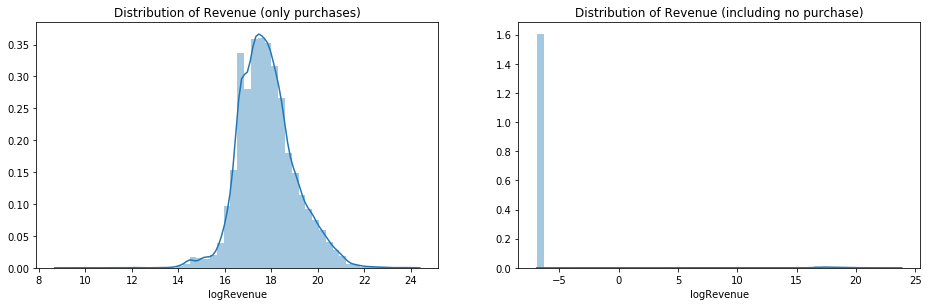

In [9]:
fig = plt.subplots(figsize=(13, 4))
plt.tight_layout()

plt.subplot(1, 2, 1)
sns.distplot(purchase_df.logRevenue)
plt.title(f"Distribution of Revenue (only purchases)")

plt.subplot(1, 2, 2)
sns.distplot(df.logRevenue)
plt.title(f"Distribution of Revenue (including no purchase)");

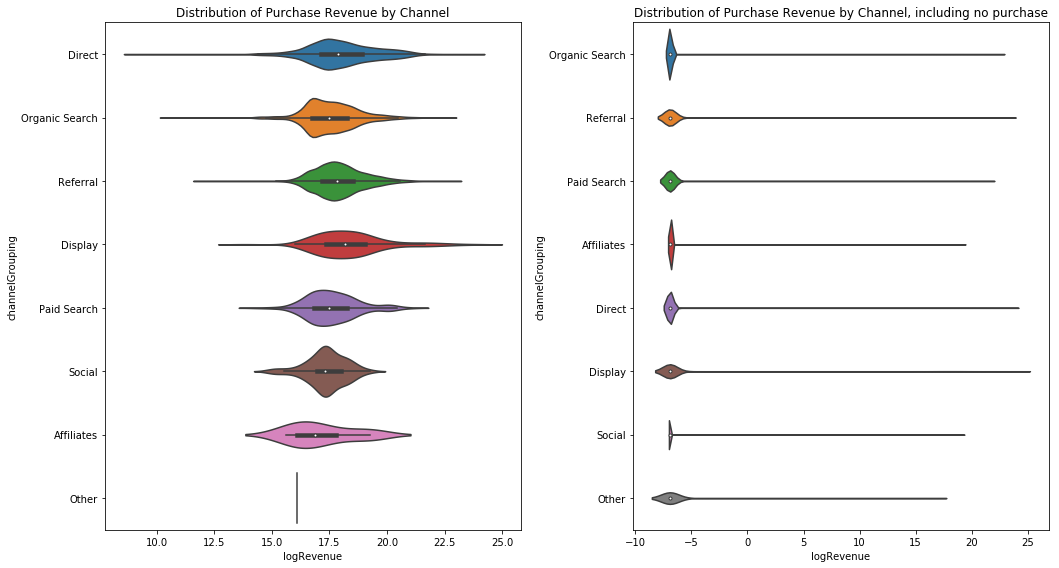

In [10]:
plt.subplots(figsize=(15,8))

plt.subplot(1,2,1)
sns.violinplot(x='logRevenue', y='channelGrouping', data=purchase_df)
plt.title('Distribution of Purchase Revenue by Channel')

plt.subplot(1,2,2)
sns.violinplot(x='logRevenue', y='channelGrouping', data=df)
plt.title('Distribution of Purchase Revenue by Channel, including no purchase')

plt.tight_layout();

In [11]:
df.date = pd.to_datetime(df.date)

In [12]:
time_df = df.groupby(by=['date']).agg({'fullVisitorId':'count', 'transactionRevenue':'sum'})

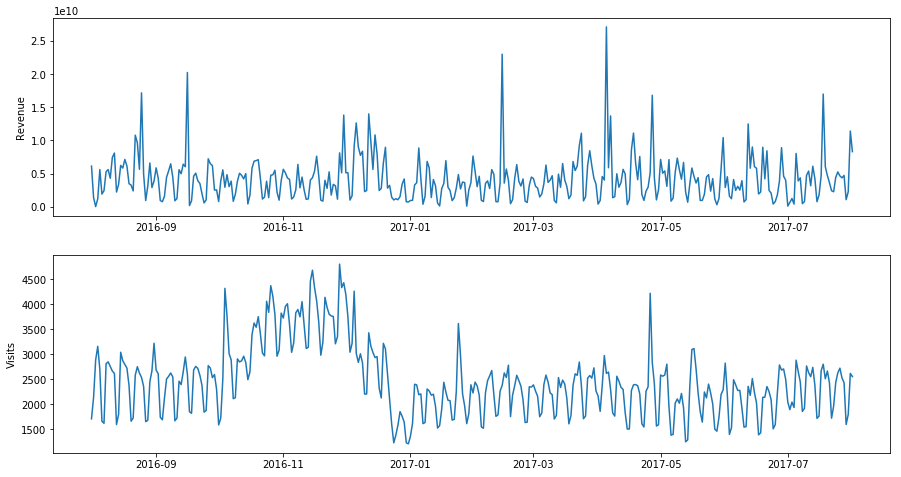

In [13]:
plt.figure(figsize=(15,8))

plt.subplot(2,1,1)
plt.plot(time_df.index,time_df['transactionRevenue'])
plt.ylabel('Revenue')

plt.subplot(2,1,2)
plt.plot(time_df.index,time_df['fullVisitorId'])
plt.ylabel('Visits');

In [14]:
country_df = df.groupby(by=['country']).agg({'fullVisitorId':'count', 'transactionRevenue':'sum'})

In [27]:
top_ten_by_rev = country_df.sort_values('transactionRevenue', ascending=False).head(10)
top_ten_by_count = country_df.sort_values('fullVisitorId', ascending=False).head(10)

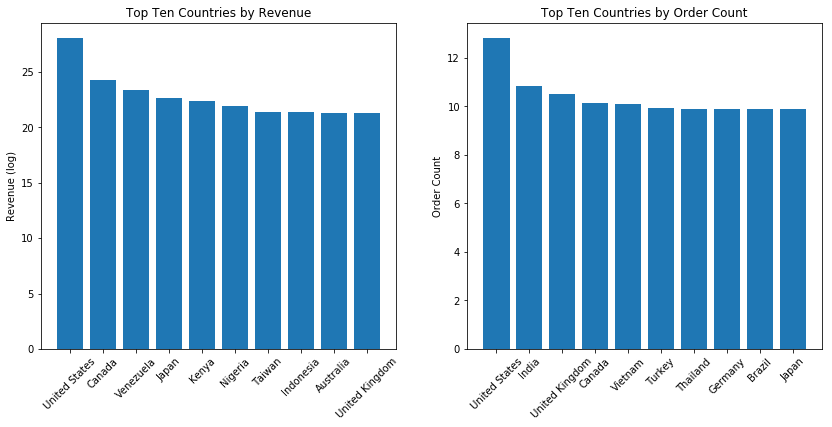

In [38]:
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
plt.bar(top_ten_by_rev.index,np.log(top_ten_by_rev['transactionRevenue']))
plt.title('Top Ten Countries by Revenue')
plt.ylabel('Revenue (log)')
plt.xticks(rotation=45)

plt.subplot(1,2,2)
plt.bar(top_ten_by_count.index,np.log(top_ten_by_count['fullVisitorId']))
plt.title('Top Ten Countries by Order Count')
plt.ylabel('Order Count')
plt.xticks(rotation=45);

In [78]:
customer_df = purchase_df.groupby(by=['fullVisitorId']).agg({'visitNumber':'count', 'transactionRevenue':'sum'})

In [79]:
customer_df = customer_df.loc[customer_df['visitNumber'] >1]

In [94]:
print(f'{len(customer_df)} out of {len(purchase_df)} customers have made repeat purchases. ({round((len(customer_df)/len(purchase_df))*100)}% of customers)')

769 out of 11515 customers have made repeat purchases. (7% of customers)


In [84]:
print(f'The most orders made by a single customer: {customer_df.visitNumber.max()}')

The most orders made by a single customer: 27


## Modeling

# Future Work